In [2]:
# 1. 필수 라이브러리 설치 (터미널이 아닌 주피터 셀에서 실행 시 !)
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
NVIDIA A100-SXM4-80GB MIG 3g.40gb


In [3]:
from sklearn.model_selection import train_test_split
import glob

# 데이터셋 클래스 수정 (파일 리스트를 직접 받을 수 있게 변경)
class DeepDetectDataset(Dataset):
    def __init__(self, file_paths=None, labels=None, root_dir=None, split='test', transform=None):
        """
        1. file_paths & labels가 있으면: 그걸 그대로 씀 (Train/Val 나눌 때 사용)
        2. 없으면: root_dir/split 폴더에서 직접 읽음 (Test 셋 읽을 때 사용)
        """
        self.transform = transform
        
        if file_paths is not None and labels is not None:
            # 리스트를 직접 받은 경우 (Train / Val 분할 시)
            self.image_paths = file_paths
            self.labels = labels
        else:
            # 폴더에서 직접 읽는 경우 (Test 셋)
            self.image_paths = []
            self.labels = []
            # 대소문자 이슈 방지를 위해 소문자로도 체크
            for label, class_name in enumerate(['Real', 'Fake']):
                class_dir = os.path.join(root_dir, split, class_name)
                if not os.path.exists(class_dir): 
                    class_dir = os.path.join(root_dir, split, class_name.lower())
                
                # 해당 폴더의 모든 이미지 파일 읽기
                if os.path.exists(class_dir):
                    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    self.image_paths.extend(files)
                    self.labels.extend([label] * len(files))
                else:
                    print(f"Warning: {class_dir} not found!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print(f"Error loading image: {img_path}")
            # 에러 발생 시 검은 이미지 반환 (학습 중단 방지)
            return torch.zeros((3, 224, 224)), torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(self.labels[idx], dtype=torch.float32)

# 논문 Listing 1에 기반한 증강 파이프라인 [cite: 91-101]
train_transform = A.Compose([
    A.Resize(224, 224, interpolation=3), # 3 = Bicubic [cite: 93]
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # [cite: 100]
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224, interpolation=3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [4]:
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 1. 경로 설정
DATA_DIR = '../data'

# =========================================================================
# [Part A] Train 데이터 로드: 기존 Train 폴더의 데이터를 100% 학습에 사용
# =========================================================================
train_paths = []
train_labels = []

# Train 폴더 순회
for label, class_name in enumerate(['Real', 'Fake']):
    class_dir = os.path.join(DATA_DIR, 'train', class_name)
    if not os.path.exists(class_dir): 
        class_dir = os.path.join(DATA_DIR, 'train', class_name.lower())
    
    if os.path.exists(class_dir):
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        train_paths.extend(files)
        train_labels.extend([label] * len(files))
        print(f"[Train] '{class_name}' 폴더에서 {len(files)}장 로드 완료")

print(f"✅ 총 학습(Train) 데이터: {len(train_paths)}장 (전부 학습에 투입)")


# =========================================================================
# [Part B] Test 데이터 로드: 불러와서 반으로 쪼개 Val / Test로 사용
# =========================================================================
all_test_paths = []
all_test_labels = []

# Test 폴더 순회 (주의: data/test/Real, data/test/Fake 구조여야 함)
for label, class_name in enumerate(['Real', 'Fake']):
    class_dir = os.path.join(DATA_DIR, 'test', class_name) # 폴더명 확인 필요
    if not os.path.exists(class_dir): 
        class_dir = os.path.join(DATA_DIR, 'test', class_name.lower())
    
    if os.path.exists(class_dir):
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_test_paths.extend(files)
        all_test_labels.extend([label] * len(files))
        print(f"[Test Source] '{class_name}' 폴더에서 {len(files)}장 로드 완료")

if len(all_test_paths) == 0:
    raise ValueError("Test 폴더에서 이미지를 찾을 수 없습니다! 경로를 확인해주세요.")

# -------------------------------------------------------------------------
# 핵심 전략: Test 셋을 50:50으로 나누어 Val과 Final Test로 활용
# -------------------------------------------------------------------------
# Stratify를 써서 Real/Fake 비율을 유지하며 나눕니다.
val_paths, final_test_paths, val_labels, final_test_labels = train_test_split(
    all_test_paths, all_test_labels, 
    test_size=0.5, 
    random_state=42, 
    stratify=all_test_labels
)

print("-" * 40)
print(f"✅ 검증(Val) 데이터 (Test의 절반): {len(val_paths)}장 -> 학습 중 성능 평가용")
print(f"✅ 최종 테스트(Test) 데이터 (나머지): {len(final_test_paths)}장 -> 최종 확인용")
print("-" * 40)


# =========================================================================
# [Part C] 데이터셋 및 로더 생성
# =========================================================================

# 1. 데이터셋 생성
# Train: 증강 적용 (train_transform)
train_dataset = DeepDetectDataset(file_paths=train_paths, labels=train_labels, transform=train_transform)

# Val & Test: 증강 없음 (val_transform) -> 정직한 평가를 위해
val_dataset = DeepDetectDataset(file_paths=val_paths, labels=val_labels, transform=val_transform)
test_dataset = DeepDetectDataset(file_paths=final_test_paths, labels=final_test_labels, transform=val_transform)

# 2. 데이터 로더 생성
# 중요: num_workers=0 (GPU 메모리 에러 방지), batch_size=64 (안전값)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

print("모든 데이터 준비 완료! 이제 학습을 시작하세요.")
print("예상: Val Accuracy가 60~70%대에서 시작하여 서서히 오를 것입니다.")

[Train] 'Real' 폴더에서 48815장 로드 완료
[Train] 'Fake' 폴더에서 41594장 로드 완료
✅ 총 학습(Train) 데이터: 90409장 (전부 학습에 투입)
[Test Source] 'Real' 폴더에서 11377장 로드 완료
[Test Source] 'Fake' 폴더에서 10399장 로드 완료
----------------------------------------
✅ 검증(Val) 데이터 (Test의 절반): 10888장 -> 학습 중 성능 평가용
✅ 최종 테스트(Test) 데이터 (나머지): 10888장 -> 최종 확인용
----------------------------------------
모든 데이터 준비 완료! 이제 학습을 시작하세요.
예상: Val Accuracy가 60~70%대에서 시작하여 서서히 오를 것입니다.


In [5]:
def get_advanced_model():
    # Pre-trained EfficientNet-B4 로드 [cite: 172]
    model = EfficientNet.from_pretrained('efficientnet-b4')
    
    # 출력 피처 수 확인 (EfficientNet-B4는 1792) [cite: 174]
    num_ftrs = model._fc.in_features 
    
    # Binary Classification Head 수정 [cite: 178]
    model._fc = nn.Sequential(
        nn.Dropout(p=0.4),            # [cite: 179]
        nn.Linear(num_ftrs, 1),       # [cite: 180]
        nn.Sigmoid()                  # [cite: 181]
    )
    return model

model = get_advanced_model().to(device)
print("Model loaded successfully.")

Loaded pretrained weights for efficientnet-b4
Model loaded successfully.


In [5]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# 손실함수 & 최적화함수 설정
criterion = nn.BCELoss() # 이진 분류 손실함수
optimizer = optim.Adam(model.parameters(), lr=1e-4) # 학습률 0.0001

def train_model(model, train_loader, val_loader, epochs=5):
    # 1. 기록 저장을 위한 리스트 생성
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_acc = 0.0
    print(f"학습 시작! (총 Epochs: {epochs})")
    
    for epoch in range(epochs):
        # --- 학습 (Train) ---
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})
            
        # Epoch 별 Train Loss 계산 및 저장
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # --- 검증 (Validation) ---
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0 # 검증 Loss 누적용 변수 추가
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                
                # 2. Validation Loss 계산 추가
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Epoch 별 Val Loss & Acc 계산 및 저장
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"\n[결과] Epoch {epoch+1} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"--> 최고 성능 갱신! 모델 저장됨 ({best_acc:.2f}%)")
            
    # 3. 저장된 기록들 반환 (Return)
    return train_losses, val_losses, val_accuracies


train_loss_history, val_loss_history, val_acc_history = train_model(model, train_loader, val_loader, epochs=3)

import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(train_loss_history) + 1),
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'val_acc': val_acc_history
})

history_df.to_csv('train_log.csv', index=False)
print("학습 기록이 'train_log.csv' 파일로 저장되었습니다.")

학습 시작! (총 Epochs: 3)


Epoch 1/3: 100%|███████████████| 1413/1413 [43:11<00:00,  1.83s/it, loss=0.0759]



[결과] Epoch 1 - Train Loss: 0.0759, Val Loss: 2.0116, Val Acc: 60.53%
--> 최고 성능 갱신! 모델 저장됨 (60.53%)


Epoch 2/3: 100%|██████████████| 1413/1413 [29:58<00:00,  1.27s/it, loss=0.00811]


KeyboardInterrupt: 

In [6]:
# 1. Test 데이터셋 로드

test_dir = '../data' 

test_dataset = DeepDetectDataset(root_dir=test_dir, split='test', transform=val_transform) 

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
print(f"테스트 데이터 개수: {len(test_dataset)}장")

model = get_advanced_model().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("최종 테스트(Final Test) 시작...")
print(f"사용하는 데이터: 위에서 분할한 {len(final_test_paths)}장 (Validation에 쓰지 않은 나머지 50%)")

# 2. 평가 진행
# ⚠️ 중요: 위에서 만든 'test_loader'를 그대로 사용합니다. (새로 만들지 않음!)
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 나중에 정밀 분석(Confusion Matrix 등)을 위해 기록
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = 100 * correct / total
print(f"\n==============================")
print(f"🏆 최종 테스트 정확도: {acc:.2f}%")
print(f"==============================")

# (선택 사항) CSV로 저장하고 싶다면
import pandas as pd
result_df = pd.DataFrame({'True_Label': [x[0] for x in y_true], 'Pred_Label': [x[0] for x in y_pred]})
result_df.to_csv('final_test_results.csv', index=False)

테스트 데이터 개수: 21776장
Loaded pretrained weights for efficientnet-b4


/tmp/ipykernel_65603/2412701054.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


최종 테스트(Final Test) 시작...
사용하는 데이터: 위에서 분할한 10888장 (Validation에 쓰지 않은 나머지 50%)


Testing: 100%|████████████████████████████████| 171/171 [01:21<00:00,  2.10it/s]


🏆 최종 테스트 정확도: 60.77%


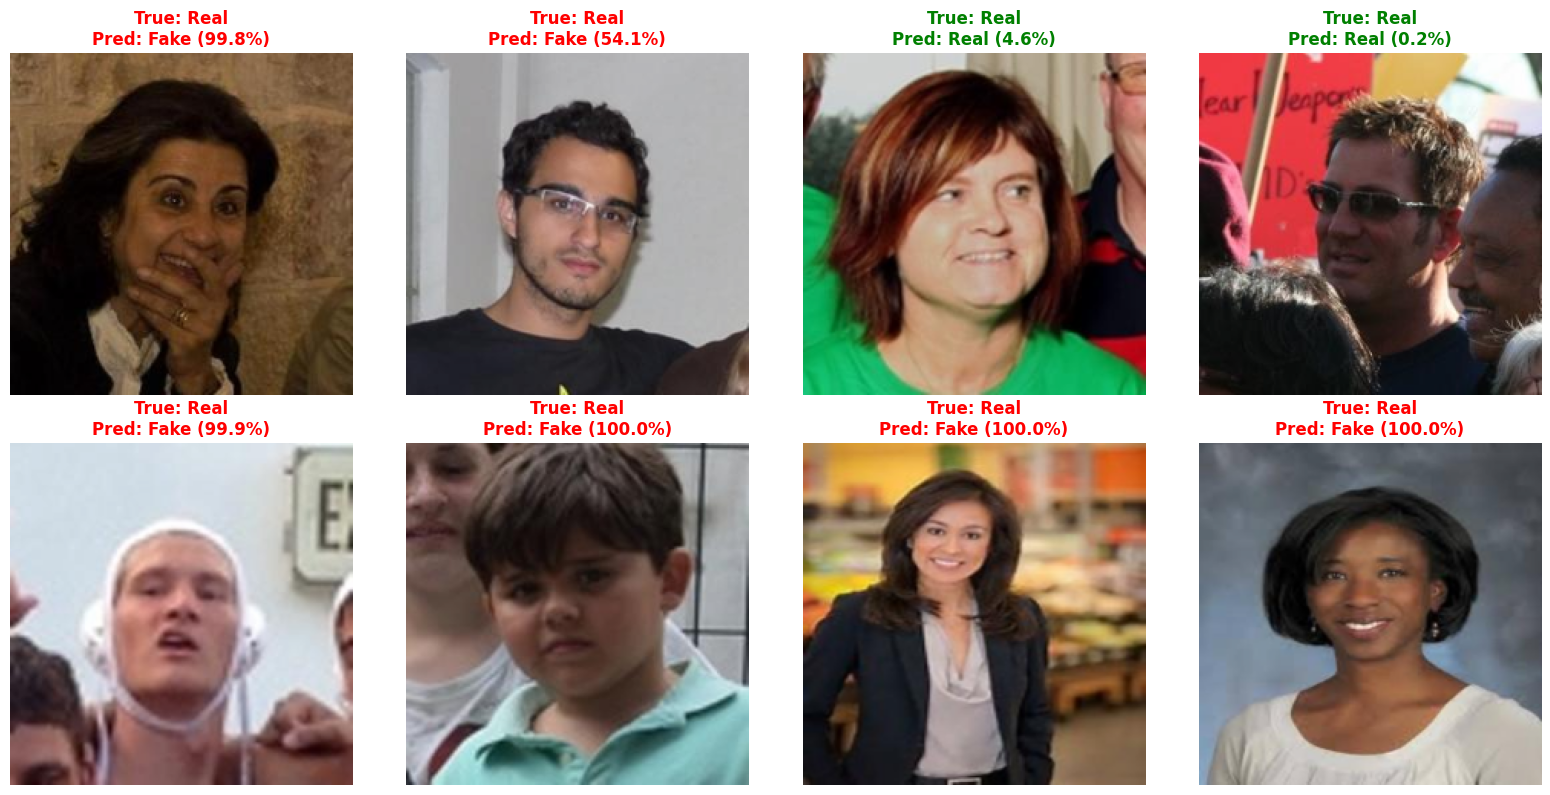

In [7]:
# 테스트 셋에서 이미지 8장만 뽑아서 시각화
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images[:8], labels[:8] # 8장만

# 모델 예측
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    preds = (outputs > 0.5).float().cpu()
    probs = outputs.cpu() # 확률값 (얼마나 확신하는지)

# 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    # 이미지 Normalize 해제 및 시각화용 변환
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    # 라벨 정보
    true_val = labels[i].item()
    pred_val = preds[i].item()
    prob_val = probs[i].item()
    
    true_str = "Fake" if true_val == 1 else "Real"
    pred_str = "Fake" if pred_val == 1 else "Real"
    
    # 맞으면 초록색, 틀리면 빨간색 제목
    color = 'green' if true_val == pred_val else 'red'
    title = f"True: {true_str}\nPred: {pred_str} ({prob_val:.1%})"
    
    ax.set_title(title, color=color, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

✅ 그래프가 'training_result_graph.png' 파일로 저장되었습니다.


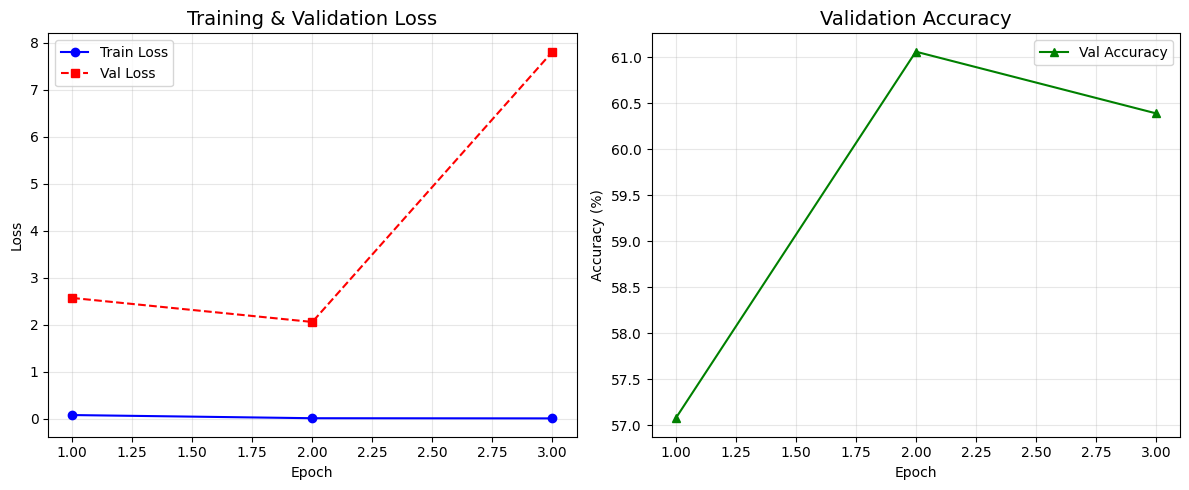

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. 저장된 로그 파일이 있다면 불러오기
if os.path.exists('train_log.csv'):
    history_df = pd.read_csv('train_log.csv')
    epochs = history_df['epoch']
    train_losses = history_df['train_loss']
    val_losses = history_df['val_loss']
    val_accuracies = history_df['val_acc']
else:
    # 파일이 없는 경우, 메모리에 있는 변수 사용 (방금 학습 마친 경우)
    try:
        epochs = range(1, len(train_loss_history) + 1)
        train_losses = train_loss_history
        val_losses = val_loss_history
        val_accuracies = val_acc_history
    except NameError:
        print("에러: 학습 데이터 변수가 메모리에 없습니다. 'train_log.csv' 파일이 있는지 확인해주세요.")
        # 빈 데이터로 에러 방지
        epochs, train_losses, val_losses, val_accuracies = [], [], [], []

# 데이터가 있을 때만 그래프 그리기
if len(epochs) > 0:
    # 2. 그래프 그리기
    plt.figure(figsize=(12, 5))

    # (1) Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color='blue', label='Train Loss')
    plt.plot(epochs, val_losses, marker='s', color='red', linestyle='--', label='Val Loss')
    plt.title('Training & Validation Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # (2) Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, marker='^', color='green', label='Val Accuracy')
    plt.title('Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # ==========================================
    # [추가됨] 그래프를 이미지 파일로 저장
    # ==========================================
    save_filename = 'training_result_graph.png'
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"✅ 그래프가 '{save_filename}' 파일로 저장되었습니다.")

    # 화면에 보여주기 (반드시 savefig 뒤에 와야 함)
    plt.show()

전체 검증 데이터 예측 중... (잠시만 기다려주세요)


100%|█████████████████████████████████████████| 171/171 [03:27<00:00,  1.21s/it]


✅ Confusion Matrix가 'confusion_matrix.png'로 저장되었습니다.


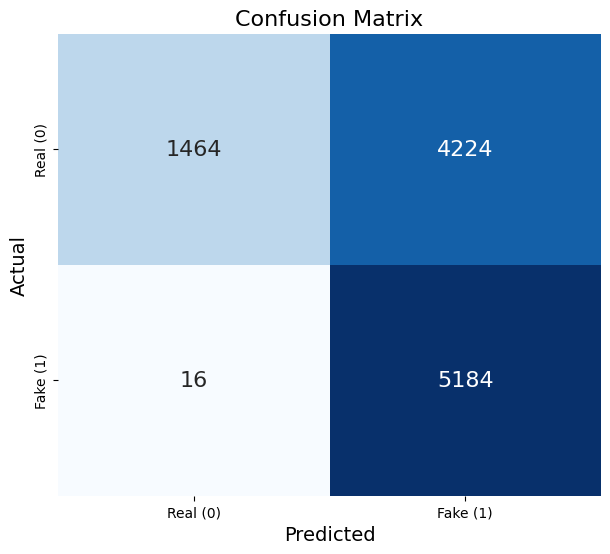


[Classification Report]
              precision    recall  f1-score   support

        Real       0.99      0.26      0.41      5688
        Fake       0.55      1.00      0.71      5200

    accuracy                           0.61     10888
   macro avg       0.77      0.63      0.56     10888
weighted avg       0.78      0.61      0.55     10888

✅ ROC Curve가 'roc_curve.png'로 저장되었습니다.


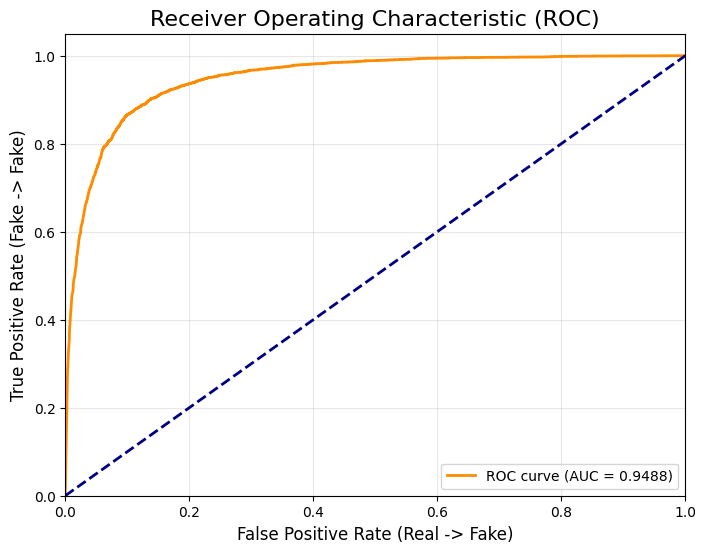

In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# 1. 검증 데이터 전체에 대해 예측 수행
y_true = []
y_pred_prob = []
y_pred_label = []

model.eval()
print("전체 검증 데이터 예측 중... (잠시만 기다려주세요)")

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        
        # 모델 예측
        outputs = model(images)
        
        # 확률값 추출 (CPU로 이동 후 1차원 배열로 변환)
        probs = outputs.cpu().numpy().flatten()
        y_pred_prob.extend(probs)
        
        # 라벨(0, 1) 결정 (threshold 0.5)
        preds = (probs > 0.5).astype(int)
        y_pred_label.extend(preds)
        
        # 정답 라벨 저장
        y_true.extend(labels.numpy().astype(int))

# -------------------------------------------------------
# A. Confusion Matrix (혼동 행렬) 시각화 및 저장
# -------------------------------------------------------
cm = confusion_matrix(y_true, y_pred_label)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16},
            xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# [저장]
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion Matrix가 'confusion_matrix.png'로 저장되었습니다.")
plt.show()

# 정밀도, 재현율 등 상세 리포트 출력
print("\n[Classification Report]")
print(classification_report(y_true, y_pred_label, target_names=['Real', 'Fake']))

# -------------------------------------------------------
# B. ROC Curve & AUC 시각화 및 저장
# -------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Real -> Fake)', fontsize=12)
plt.ylabel('True Positive Rate (Fake -> Fake)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# [저장]
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("✅ ROC Curve가 'roc_curve.png'로 저장되었습니다.")
plt.show()

Grad-CAM 생성 중... (Fake 이미지를 찾는 중)
✅ Attention Map이 'grad_cam_result.png' 파일로 저장되었습니다.


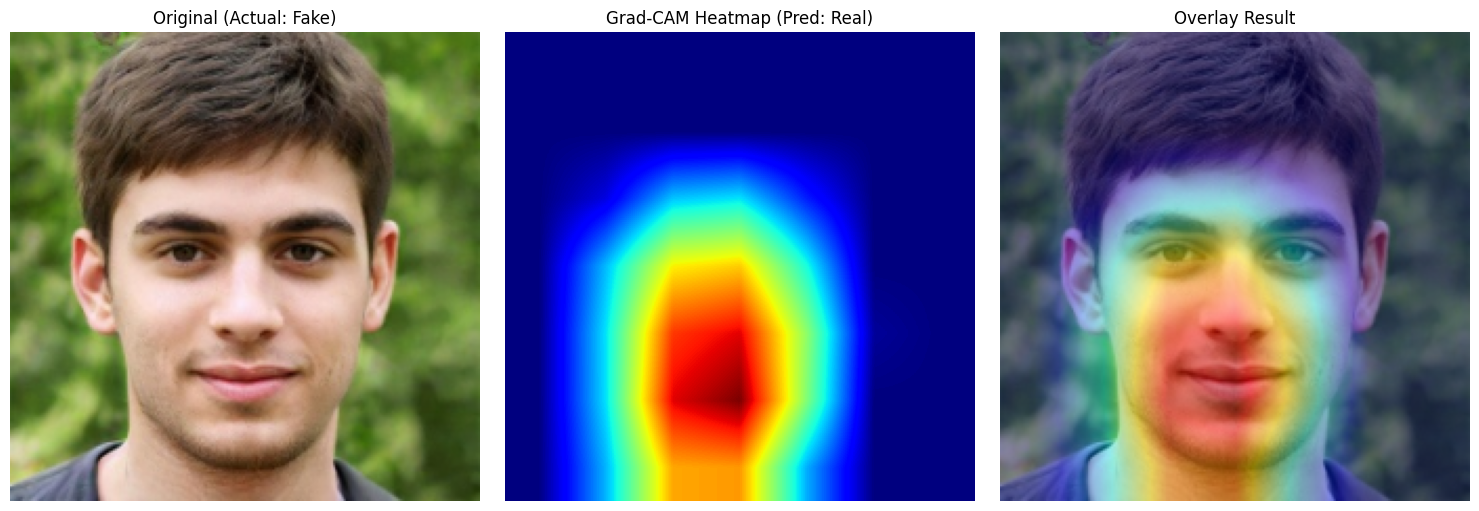

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# -------------------------------------------------------
# 1. Grad-CAM 클래스 정의 (안전 장치 추가됨)
# -------------------------------------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hook 등록
        # (주의: PyTorch 버전에 따라 backward hook 동작이 다를 수 있어 호환성 유지)
        target_layer.register_forward_hook(self.save_activation)
        try:
            target_layer.register_full_backward_hook(self.save_gradient)
        except AttributeError:
            target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output[0]는 해당 레이어의 출력에 대한 그라디언트
        self.gradients = grad_output[0]

    def __call__(self, x):
        # 1. Forward Pass
        output = self.model(x)
        
        # 2. Backward Pass (Target: 예측된 클래스의 점수)
        self.model.zero_grad()
        
        # 가장 높은 점수를 가진 클래스에 대해 역전파 수행
        target_index = output.argmax(dim=1).item()
        score = output[0, target_index]
        
        score.backward()
        
        # 3. Grad-CAM 계산
        gradients = self.gradients.cpu().data.numpy()[0] # (Channels, H, W)
        activations = self.activations.cpu().data.numpy()[0] # (Channels, H, W)
        
        # Global Average Pooling (채널별 중요도 가중치 계산)
        weights = np.mean(gradients, axis=(1, 2))
        
        # 가중치와 피처맵 결합
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        # ReLU (양의 영향력만 남김)
        cam = np.maximum(cam, 0)
        
        # 원본 이미지 크기로 확대 (224x224)
        cam = cv2.resize(cam, (224, 224))
        
        # 0~1 정규화 (ZeroDivisionError 방지 포함)
        cam = cam - np.min(cam)
        if np.max(cam) != 0:
            cam = cam / np.max(cam)
            
        return cam, target_index

# -------------------------------------------------------
# 2. 실행 및 이미지 찾기
# -------------------------------------------------------
print("Grad-CAM 생성 중... (Fake 이미지를 찾는 중)")

# EfficientNet-B4의 마지막 Conv 레이어 (Features 추출 직후)
target_layer = model._conv_head 
grad_cam = GradCAM(model, target_layer)

# 모델을 평가 모드로 설정하되, 그라디언트 계산은 켜둡니다.
model.eval() 

img_tensor = None
label_val = None

# Validation Set에서 'Fake(1)' 라벨인 이미지 하나 찾기
found = False
for imgs, lbls in val_loader:
    for i in range(len(lbls)):
        if lbls[i] == 1: # Fake 이미지 발견 시
            img_tensor = imgs[i].unsqueeze(0).to(device) # (1, 3, 224, 224)
            img_tensor.requires_grad = True # 그라디언트 추적 켜기
            label_val = lbls[i].item()
            found = True
            break
    if found:
        break

if img_tensor is None:
    print("경고: Fake 이미지를 찾지 못했습니다. 데이터셋을 확인하세요.")
else:
    # -------------------------------------------------------
    # 3. 히트맵 생성 및 시각화
    # -------------------------------------------------------
    heatmap, pred_idx = grad_cam(img_tensor)
    
    pred_str = "Fake" if pred_idx == 1 else "Real"
    actual_str = "Fake" if label_val == 1 else "Real"

    # 원본 이미지 복구 (Denormalization)
    origin_img = img_tensor.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    origin_img = (origin_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    origin_img = np.clip(origin_img, 0, 1)

    # 히트맵 컬러 입히기 (JET Colormap)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    heatmap_color = np.float32(heatmap_color) / 255

    # 오버레이 (원본 60% + 히트맵 40%)
    overlay = heatmap_color * 0.4 + origin_img * 0.6
    overlay = np.clip(overlay, 0, 1)

    # 그래프 그리기
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(origin_img)
    ax[0].set_title(f"Original (Actual: {actual_str})")
    
    ax[1].imshow(heatmap, cmap='jet')
    ax[1].set_title(f"Grad-CAM Heatmap (Pred: {pred_str})")
    
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay Result")
    
    for a in ax: 
        a.axis('off')

    plt.tight_layout()
    
    # [저장]
    save_filename = 'grad_cam_result.png'
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Attention Map이 '{save_filename}' 파일로 저장되었습니다.")
    
    plt.show()

✅ 점수 분포 그래프가 'score_distribution.png' 파일로 저장되었습니다.


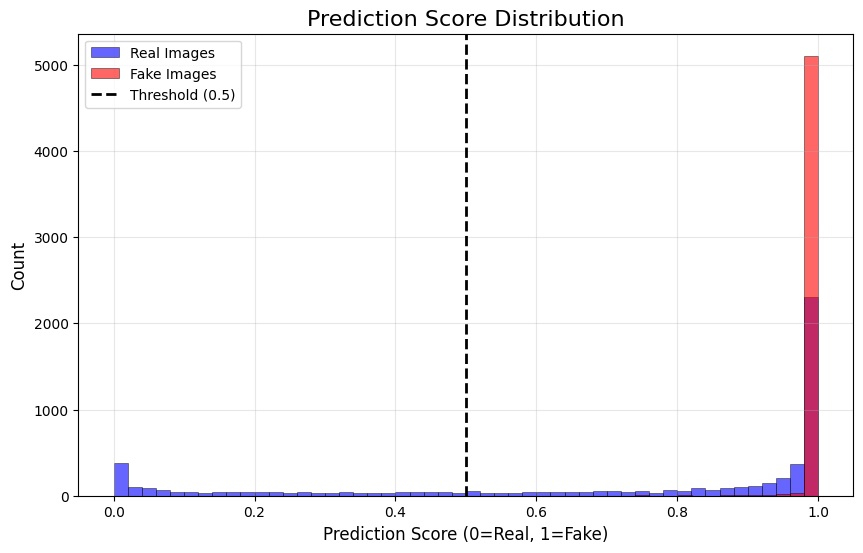

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 존재 여부 확인 (이전 셀을 실행했는지 체크)
if 'y_pred_prob' not in locals() or 'y_true' not in locals():
    print("에러: 예측 데이터(y_pred_prob)가 없습니다. 'Confusion Matrix' 코드를 먼저 실행해주세요.")
else:
    plt.figure(figsize=(10, 6))

    # 2. Real 데이터와 Fake 데이터의 예측 확률 분리
    # (리스트 컴프리헨션 사용)
    real_probs = [p for p, t in zip(y_pred_prob, y_true) if t == 0]
    fake_probs = [p for p, t in zip(y_pred_prob, y_true) if t == 1]

    # 3. 히스토그램 그리기
    # edgecolor='black'을 추가하면 막대 구분이 더 잘 됩니다.
    plt.hist(real_probs, bins=50, alpha=0.6, label='Real Images', color='blue', edgecolor='black', linewidth=0.5)
    plt.hist(fake_probs, bins=50, alpha=0.6, label='Fake Images', color='red', edgecolor='black', linewidth=0.5)

    # 기준선 (Threshold 0.5)
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')

    plt.xlabel('Prediction Score (0=Real, 1=Fake)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Prediction Score Distribution', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 그래프 파일로 저장
    save_filename = 'score_distribution.png'
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"✅ 점수 분포 그래프가 '{save_filename}' 파일로 저장되었습니다.")

    plt.show()